In [1]:
%matplotlib inline

import pymor.tools.random
pymor.tools.random._default_random_state = None

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')

The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


In [2]:
import numpy as np
from pymor.basic import *

In [3]:
problem = thermal_block_problem((3,3))
fom, _ = discretize_stationary_cg(problem, diameter=1/100)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [4]:
parameter_space = fom.parameters.space(0.0001, 1.)

In [5]:
fom.parameters

Parameters({diffusion: 9})

In [6]:
training_set = parameter_space.sample_randomly(25)
print(training_set)

[Mu({diffusion: [0.37460266483547777, 0.9507192349792751, 0.7320207424172239, 0.5986986183486169, 0.15610303857839228, 0.15607892088416903, 0.05817780380698265, 0.8661895281603577, 0.6011549002420344]}), Mu({diffusion: [0.7081017705382658, 0.020682435846372867, 0.9699128611767781, 0.8324593965363417, 0.21241787676720833, 0.1819067847103799, 0.18348616940244847, 0.30431181873524177, 0.5248039559890746]}), Mu({diffusion: [0.43200182414025157, 0.2913000172840221, 0.6118917094329073, 0.13957991126597663, 0.2922154340703646, 0.3664252071093623, 0.4561243772186142, 0.7851974437968743, 0.1997538147801439]}), Mu({diffusion: [0.5142830149697702, 0.5924553274051563, 0.04654576767872573, 0.6075840974162482, 0.17060707127492278, 0.065145087825981, 0.9488906486996079, 0.9656354698712519, 0.8084165083816495]}), Mu({diffusion: [0.30468330779645336, 0.09776234679498323, 0.6842646032095057, 0.4402084784902273, 0.12212603102129435, 0.49522739242025904, 0.03448508226310688, 0.9093294700385742, 0.25885410

In [7]:
U = fom.solution_space.empty()
for mu in training_set:
    U.append(fom.solve(mu))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [8]:
fom.solution_space

NumpyVectorSpace(20201, id='STATE')

In [9]:
len(U)

25

In [10]:
fom.visualize(U)

<pymor.discretizers.builtin.gui.jupyter.matplotlib.visualize_patch.<locals>.Plot at 0x7f28486fedd0>

In [11]:
trivial_basis = U.copy()

In [12]:
V = fom.solve(parameter_space.sample_randomly(1)[0])

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [13]:
G = trivial_basis.gramian()

In [14]:
R = trivial_basis.inner(V)

In [15]:
assert R.shape == (25,1)

In [16]:
lambdas = np.linalg.solve(G, R)

In [17]:
V_proj = trivial_basis.lincomb(lambdas.T)

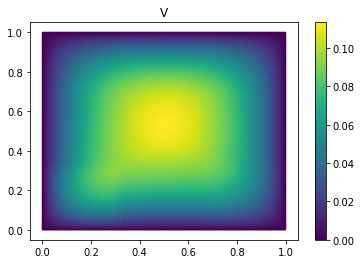

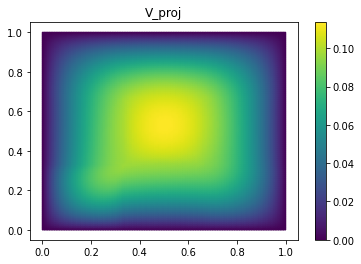

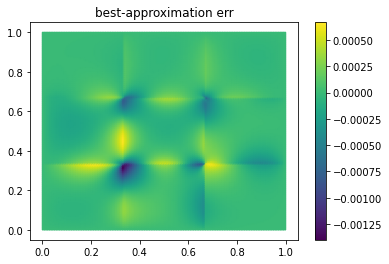

Output()

In [18]:
fom.visualize((V, V_proj, V - V_proj),
              legend=('V', 'V_proj', 'best-approximation err'),
              separate_colorbars=True)

In [19]:
fom.h1_0_semi_product

NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='h1_0_semi')

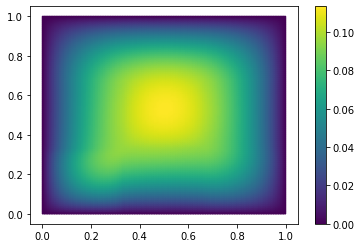

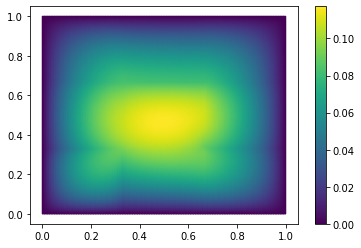

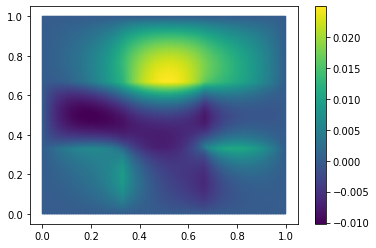

Output()

In [20]:
G = trivial_basis[:10].gramian(product=fom.h1_0_semi_product)
R = trivial_basis[:10].inner(V, product=fom.h1_0_semi_product)
lambdas = np.linalg.solve(G, R)
V_h1_proj = trivial_basis[:10].lincomb(lambdas.T)

fom.visualize((V, V_h1_proj, V - V_h1_proj), separate_colorbars=True)

In [21]:
validation_set = parameter_space.sample_randomly(100)
V = fom.solution_space.empty()
for mu in validation_set:
    V.append(fom.solve(mu))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [22]:
def compute_proj_errors(basis, V, product):
    G = basis.gramian(product=product)
    R = basis.inner(V, product=product)
    errors = []
    for N in range(len(basis) + 1):
        if N > 0:
            v = np.linalg.solve(G[:N, :N], R[:N, :])
        else:
            v = np.zeros((0, len(V)))
        V_proj = basis[:N].lincomb(v.T)
        errors.append(np.max((V - V_proj).norm(product=product)))
    return errors

trivial_errors = compute_proj_errors(trivial_basis, V, fom.h1_0_semi_product)

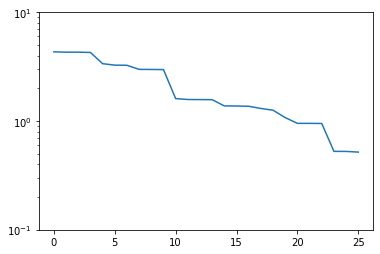

In [23]:
from matplotlib import pyplot as plt
plt.figure()
plt.semilogy(trivial_errors)
plt.ylim(1e-1, 1e1)
plt.show()

In [24]:
def strong_greedy(U, product, N):
    basis = U.space.empty()

    for n in range(N):
        # compute projection errors
        G = basis.gramian(product)
        R = basis.inner(U, product=product)
        lambdas = np.linalg.solve(G, R)
        U_proj = basis.lincomb(lambdas.T)
        errors = (U - U_proj).norm(product)

        # extend basis
        basis.append(U[np.argmax(errors)])

    return basis

In [25]:
greedy_basis = strong_greedy(U, fom.h1_0_product, 25)

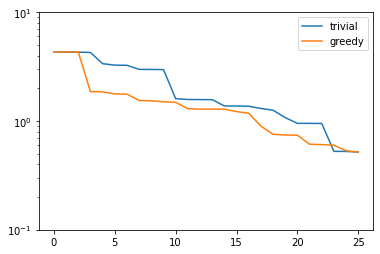

In [26]:
greedy_errors = compute_proj_errors(greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

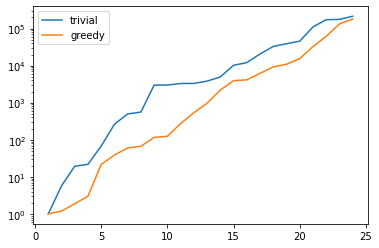

In [27]:
G_trivial = trivial_basis.gramian(fom.h1_0_semi_product)
G_greedy = greedy_basis.gramian(fom.h1_0_semi_product)
trivial_conds, greedy_conds = [], []
for N in range(1, len(U)):
    trivial_conds.append(np.linalg.cond(G_trivial[:N, :N]))
    greedy_conds.append(np.linalg.cond(G_greedy[:N, :N]))
plt.figure()
plt.semilogy(range(1, len(U)), trivial_conds, label='trivial')
plt.semilogy(range(1, len(U)), greedy_conds, label='greedy')
plt.legend()
plt.show()

In [28]:
gram_schmidt(greedy_basis, product=fom.h1_0_semi_product, copy=False)
gram_schmidt(trivial_basis, product=fom.h1_0_semi_product, copy=False)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

NumpyVectorArray(
    [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.72400995e-04
       6.40708268e-04  2.44342521e-04]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.88622177e-04
       1.22198234e-04  4.55954601e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.83897552e-03
       1.91768253e-03  7.54420981e-04]
     ...
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.50683737e-05
      -5.06370720e-05 -2.30770353e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.52117861e-05
      -3.23210341e-05 -1.97290029e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.70725037e-04
      -2.05655123e-04 -9.13433643e-05]],
    NumpyVectorSpace(20201, id='STATE'))

In [29]:
G_trivial = trivial_basis.gramian(fom.h1_0_semi_product)
G_greedy = greedy_basis.gramian(fom.h1_0_semi_product)

print(f'trivial: {np.linalg.cond(G_trivial)}, '
      f'greedy: {np.linalg.cond(G_greedy)}')

trivial: 1.0000000000001164, greedy: 1.000000000000069


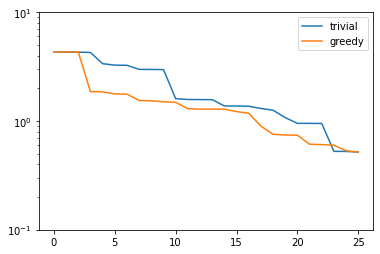

In [30]:
def compute_proj_errors_orth_basis(basis, V, product):
    errors = []
    for N in range(len(basis) + 1):
        v = V.inner(basis[:N], product=product)
        V_proj = basis[:N].lincomb(v)
        errors.append(np.max((V - V_proj).norm(product)))
    return errors

trivial_errors = compute_proj_errors_orth_basis(trivial_basis, V, fom.h1_0_semi_product)
greedy_errors  = compute_proj_errors_orth_basis(greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

In [31]:
pod_basis, pod_singular_values = pod(U, product=fom.h1_0_semi_product, modes=25)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [32]:
np.linalg.cond(pod_basis.gramian(fom.h1_0_semi_product))

1.0000000000074891

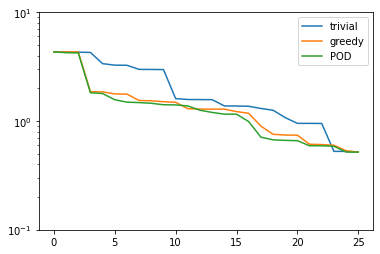

In [33]:
pod_errors = compute_proj_errors_orth_basis(pod_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.semilogy(pod_errors, label='POD')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

In [34]:
fom.visualize(pod_basis)

<pymor.discretizers.builtin.gui.jupyter.matplotlib.visualize_patch.<locals>.Plot at 0x7f2837954ed0>

In [35]:
reductor = CoerciveRBReductor(
    fom,
    product=fom.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)

In [36]:
greedy_data = rb_greedy(fom, reductor, parameter_space.sample_randomly(1000),
                        max_extensions=25)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [37]:
weak_greedy_basis = reductor.bases['RB']

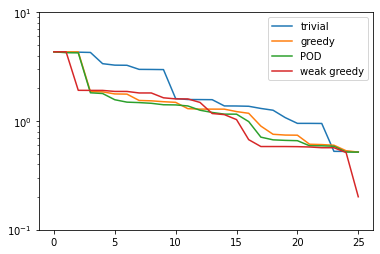

In [38]:
weak_greedy_errors = compute_proj_errors_orth_basis(weak_greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.semilogy(pod_errors, label='POD')
plt.semilogy(weak_greedy_errors, label='weak greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()